In [1]:
import numpy as np
from pydpmd.data import RigidBumpy, load
from pydpmd.plot import draw_particles_frame, create_animation, downsample
from correlation_functions import compute_msd, compute_shear_modulus, compute_rotational_msd, compute_pair_correlation_function, compute_vacf, compute_rotational_msd
from pydpmd.calc import run_binned, fused_msd_kernel, TimeBins, LagBinsExact, LagBinsLog, LagBinsLinear, LagBinsPseudoLog, requires_fields
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import os
import re
from tqdm import tqdm
from scipy.optimize import minimize
def obj_func(b, x, y):
    return np.sum((x + b - y) ** 2)

def get_relaxation_time(f, t):
    tau = np.interp(1 / np.e, f[::-1], t[::-1])
    if not np.min(f) < 1 / np.e:
        return np.nan
    return tau

In [5]:
values = {}
trial_id = 0
while True:
    # root = f'/home/mmccraw/dev/data/10-01-25/calculate-shear-modulus-final/trial-{trial_id}'
    root = f'/home/mmccraw/dev/data/10-01-25/calculate-shear-modulus-small/trial-{trial_id}'
    # root = f'/home/mmccraw/dev/data/10-01-25/calculate-shear-modulus/trial-{trial_id}'
    if not os.path.exists(root):
        break
    trial_id += 1
    i = 0
    while True:
        path = os.path.join(root, f"shear_modulus_{i}.npz")
        if not os.path.exists(path):
            break
        data = np.load(path)

        G = data['shear_modulus']
        t = data['t']
        mu_eff = np.round(data['mu_eff'], 5)
        nv = data['nv']
        phi = np.round(data['packing_fraction'], 5)

        for j in range(G.shape[1]):
            mu = mu_eff[j]
            n = nv[j]
            if (mu, n) not in values:
                values[(mu, n)] = {}
            if phi[j] not in values[(mu, n)]:
                values[(mu, n)][phi[j]] = []
            values[(mu, n)][phi[j]].append([G[:, j], t])
        i += 1

shear_modulus_data = {}
for mu_n_key in values.keys():
    g_data, t_data, phi_data = [], [], []
    for i, phi_key in enumerate(values[mu_n_key].keys()):
        g, t = np.mean(np.array(values[mu_n_key][phi_key], dtype=object), axis=0)
        g_data.append(g)
        t_data.append(t)
        phi_data.append(phi_key)
    g_data = np.array(g_data).astype(float)
    t_data = np.array(t_data).astype(float)
    phi_data = np.array(phi_data).astype(float)
    shear_modulus_data[mu_n_key] = {'g': g_data, 't': t_data, 'phi': phi_data}

In [6]:
# fit prony series
# test convergence to __spectra__ for varied number of terms in prony series using model data
# WE DONT WANT TO PLOT DATA THAT HAS OVERLAPS: use the overlaps-pe-pressure hp data to cut out packing fractions that have vertex overlaps > 10 * the average low,density data

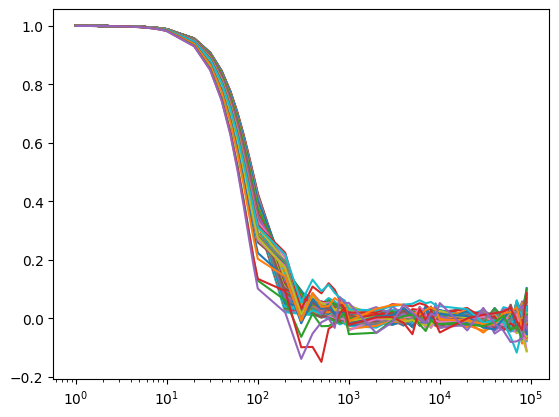

In [7]:
for nv in nv_unique:
    for k in keys:
        if k[1] != nv:
            continue
        mu_eff = k[0]
        for g, t, phi in zip(shear_modulus_data[k]['g'], shear_modulus_data[k]['t'], shear_modulus_data[k]['phi']):
            plt.plot(t, g / g[0])
        plt.xscale('log')
        break
    break

In [8]:
k

(np.float64(0.00816), np.int32(4))

/tmp/ipykernel_2459586/559675895.py:14: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[0].scatter(shear_modulus_data[k]['phi'], G_0, c=cmap(mu_eff_norm(mu_eff)))
/tmp/ipykernel_2459586/559675895.py:15: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[1].scatter(shear_modulus_data[k]['phi'], tau, c=cmap(mu_eff_norm(mu_eff)))


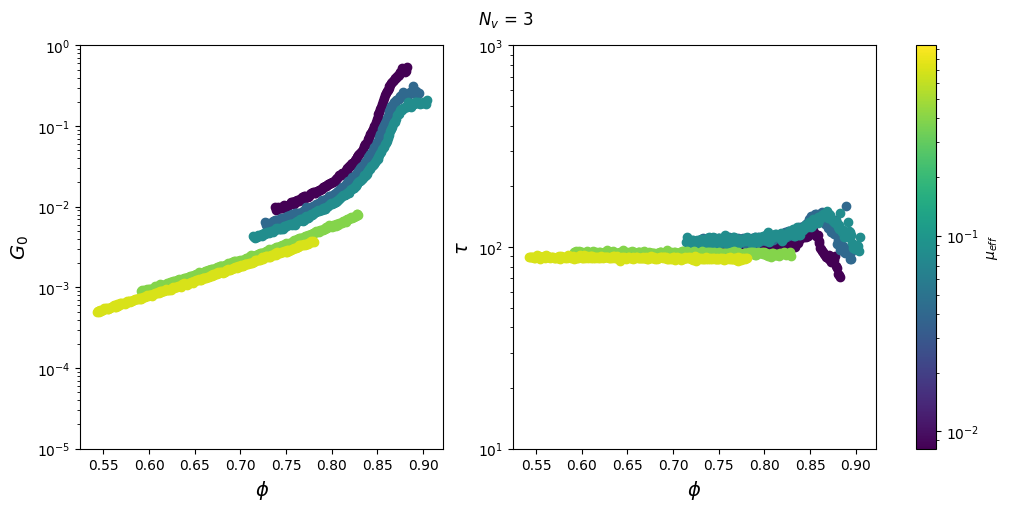

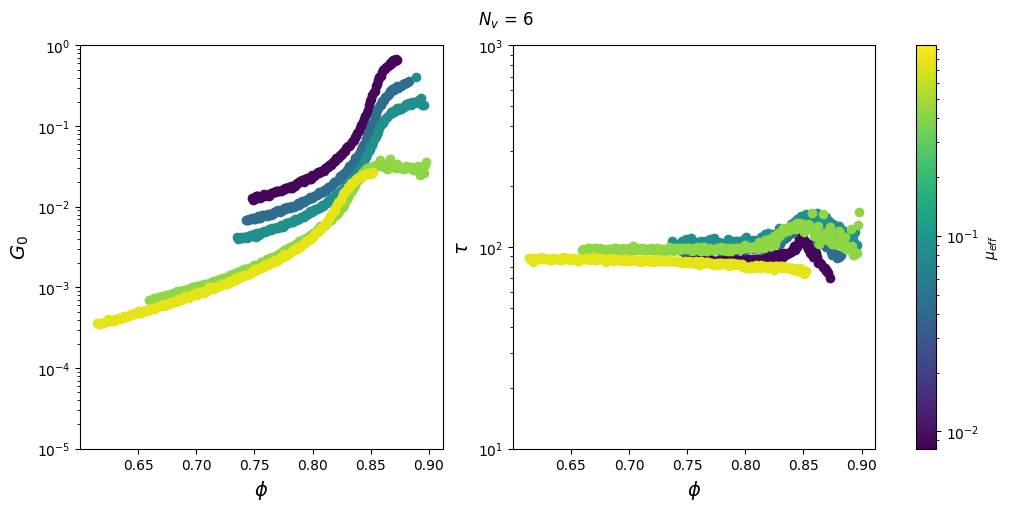

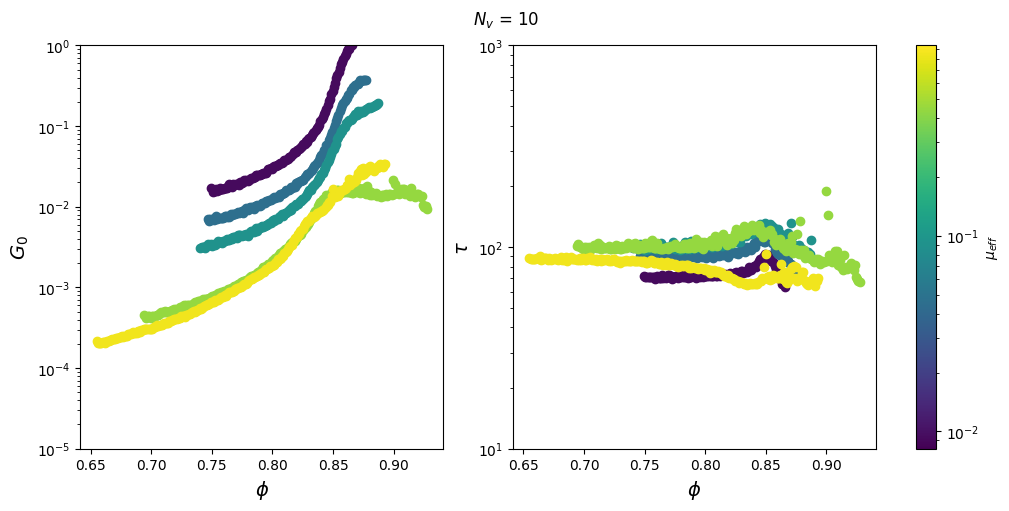

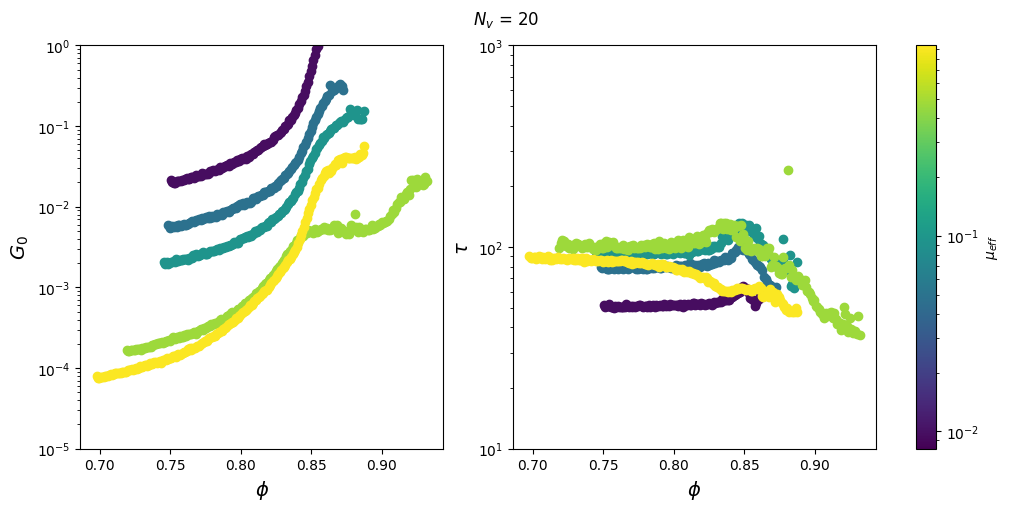

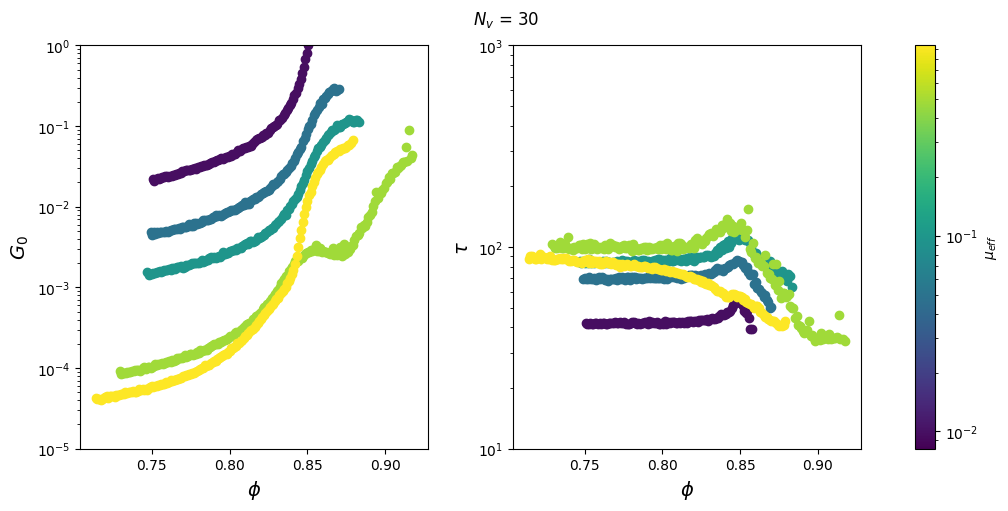

In [9]:
keys = list(shear_modulus_data.keys())
mu_eff_unique = np.unique(np.array(keys)[:, 0])
nv_unique = np.unique(np.array(keys)[:, 1])
mu_eff_norm = LogNorm(min(mu_eff_unique), max(mu_eff_unique))
cmap = plt.cm.viridis
for nv in nv_unique:
    fig, ax = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)
    for k in keys:
        if k[1] != nv:
            continue
        mu_eff = k[0]
        tau = [get_relaxation_time(g / g[0], t) for g, t in zip(shear_modulus_data[k]['g'], shear_modulus_data[k]['t'])]
        G_0 = [g[0] for g in shear_modulus_data[k]['g']]
        ax[0].scatter(shear_modulus_data[k]['phi'], G_0, c=cmap(mu_eff_norm(mu_eff)))
        ax[1].scatter(shear_modulus_data[k]['phi'], tau, c=cmap(mu_eff_norm(mu_eff)))
    for a in ax:
        a.set_yscale('log')
        a.set_xlabel(r'$\phi$', fontsize=14)
    ax[0].set_ylabel(r'$G_0$', fontsize=14)
    ax[1].set_ylabel(r'$\tau$', fontsize=14)
    ax[0].set_ylim(1e-5, 1e0)
    ax[1].set_ylim(1e1, 1e3)
    plt.suptitle(fr'$N_v$ = {int(nv) - 1}')
    sm = plt.cm.ScalarMappable(norm=mu_eff_norm, cmap=cmap)
    sm.set_array(mu_eff_unique)
    cbar = plt.colorbar(sm, ax=ax, label=r'$\mu_{eff}$')
    plt.show()



In [ ]:
mu_eff

np.float64(0.00816)